In [1]:
import glob
import os
import csv
import random
import math
import zipfile
import io
from itertools import product

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import manifold, datasets, decomposition
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ExpSineSquared, ConstantKernel as C
from sklearn.model_selection import train_test_split

In [3]:

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel as C

# Load Data

In [4]:
def read_data(path):
    data = []
    
    for file_path in glob.glob(f'{path}/**/Magnetometer.csv', recursive=True):
        df = pd.read_csv(file_path, delimiter='\t')
        cord = file_path.split('/')[2].split('_')[2:]
        cord = (float(cord[0]), float(cord[1]))
        
        mean_mag = df[["X (µT)", "Y (µT)", "Z (µT)"]].mean().to_numpy()
#         data.append(np.concatenate((cord, mean_mag)))
        data.append(np.concatenate((cord, mean_mag)))
        
    return np.array(data)

In [5]:
grid_data = read_data('./Grid/')
float_grid_data = read_data('./FloatGrid/')
testing_grid_data = read_data('./TestingGrid/')

In [7]:
grid_data[:, :2] = grid_data[:, :2] * 0.6

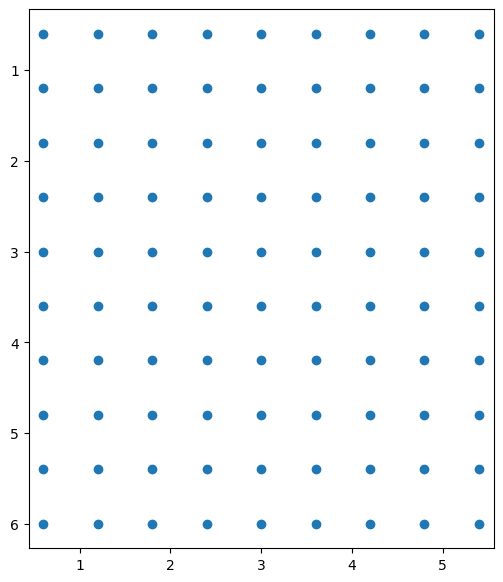

In [8]:
grid_x = grid_data[:, 1]
grid_y = grid_data[:, 0]

plt.figure(figsize=(6, 7))
plt.scatter(grid_x, grid_y)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

In [22]:
np.argsort((0, 0, 5))

array([0, 1, 2])

In [24]:
sample_count = np.zeros(len(grid_data))

def balance_sample():
    candidate_idx = np.where(sample_count == np.min(sample_count))[0]
    
    select_idx = np.random.choice(candidate_idx, 1)[0]
    sample_count[select_idx] += 1
    
    return select_idx

In [29]:
def generate_trajectory(grids, length=10, max_angle=60, min_distance=0.5, max_distance=0.9):
    def find_neighbor(previous_point, current_point):
        momentum = current_point[:2] - previous_point[:2]
        momentum_distance = np.sqrt(np.sum(np.power(momentum, 2), axis=-1))
        
        grid_vector = grids[:, :2] - current_point[:2]
        grid_distance = np.sqrt(np.sum(np.power(grid_vector, 2), axis=-1))
        
        angle = np.arccos(np.sum(grid_vector * momentum, axis=-1) / (grid_distance * momentum_distance + 1e-6)) / np.pi * 180
        
        condiction = (angle <= max_angle) & (min_distance <= grid_distance) & (grid_distance <= max_distance)
        if np.any(condiction):
            candidate = grids[condiction]
        else:
            candidate = grids[((min_distance - 0.1) <= grid_distance) & (grid_distance <= (max_distance + 0.1))]
            
        rnd_idx = np.random.choice(len(candidate), 1)[0]
        return candidate[rnd_idx]
    
#     rnd_idx = np.random.choice(len(grids), 1)[0]
    rnd_idx = balance_sample()
    prevoius_point = grids[rnd_idx]
    current_point = find_neighbor(prevoius_point, prevoius_point)
    
    traj = [prevoius_point, current_point]
    
    while len(traj) < length:
        next_point = find_neighbor(prevoius_point, current_point)
        
        traj.append(next_point)
        
        prevoius_point = current_point
        current_point = next_point
        
    return np.array(traj)

In [35]:
training_traj = [generate_trajectory(grid_data, length=50) for i in range(1000)]
training_traj = np.array(training_traj)[:, ::-1]
training_traj.shape

(1000, 50, 5)

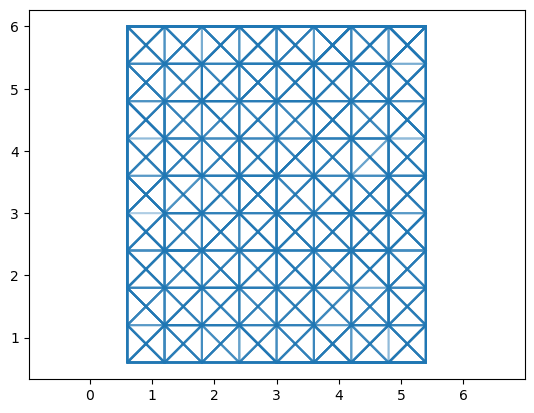

In [36]:
plt.figure()

plt.plot(training_traj[::10, :, 1].T, training_traj[::10, :, 0].T, c='tab:blue', alpha=0.2)

plt.axis('equal')
plt.show()

In [37]:
np.save(f'./Data/training_traj_0.6.npy', training_traj)